# Modules

In [1]:
# Preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import datetime as dt

# Outlier handling and future sales prediction
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost

# Data

In [2]:
# Data sales (Caspeco)
df_sales = pd.read_csv('data/caspecoTrainingData.csv')
df_test = pd.read_csv('data/caspecoTestRange.csv')

# Data weather (SMHI), no date shifting needed as SMHI forecasts have an accuracy above 80%
df_weather = pd.read_csv('data/weather_data.csv')
df_weather.drop(columns='Precipitation', inplace=True)

# Data Covid-19 (Socialstyrelsen), shift date forward by one day
df_covid = pd.read_csv('data/covid19_data.csv')
df_covid.drop(columns='NotCovidPatients', inplace=True)
df_covid['Date'] = (pd.to_datetime(df_covid['Date']) + pd.DateOffset(days=1)).dt.strftime('%Y-%m-%d')

# Data holidays (Nager)
years = ['2020', '2021', '2022', '2023']

# Fetch data from API for each year
for year in years:
    response = requests.get(f'https://date.nager.at/api/v3/publicholidays/{year}/SE')
    
    if response.status_code == 200:
        # Convert API response to dataframe
        df_year = pd.DataFrame(response.json())
        df_year = df_year[['date', 'name']]
        
        if year == '2020':
            df_holidays = df_year
        else:
            # Merge holiday data for each year
            df_holidays = pd.merge(df_holidays, df_year, on=['date', 'name'], how='outer')
            
        print(f'API request for {year} successful')
    else:
        print(f'API request for {year} failed with status code {response.status_code}')

# Factorize holiday names and rename columns
df_holidays['name'] = pd.factorize(df_holidays['name'])[0]
df_holidays = df_holidays.rename(columns={'date': 'Date', 'name': 'Holiday'})

# Missing dates
all_dates = pd.date_range(start=df_sales['Date'].min(), end=df_sales['Date'].max())
full_index = pd.MultiIndex.from_product([all_dates, df_sales['Company'].unique()], names=['Date', 'Company'])

# Reindex dataframe to fill missing dates
df_dates = df_sales.set_index(['Date', 'Company']).reindex(full_index).fillna(method='ffill').reset_index()
df_dates['Date'] = df_dates['Date'].astype(str)
df_dates.drop(columns='Sales', inplace=True)

API request for 2020 successful
API request for 2021 successful
API request for 2022 successful
API request for 2023 successful


In [3]:
# Merge dates and sales (training set)
df = pd.merge(df_sales, df_dates, on=['Date', 'Company'], how='right')

# Add holidays feature
df = pd.merge(df, df_holidays, on='Date', how='left')
df['Holiday'] = df['Holiday'].fillna(16).astype(int)
df_test = pd.merge(df_test, df_holidays, on='Date', how='left')
df_test['Holiday'] = df_test['Holiday'].fillna(16).astype(int)

# Add temperature feature
df = pd.merge(df, df_weather, on='Date', how='left')
df_test = pd.merge(df_test, df_weather, on='Date', how='left')

# Add Covid-19 ICU patients feature
df = pd.merge(df, df_covid, on='Date', how='left')
df['CovidPatients'] = df['CovidPatients'].fillna(0).astype(int)
df_test = pd.merge(df_test, df_covid, on='Date', how='left')
df_test['CovidPatients'] = df_test['CovidPatients'].fillna(0).astype(int)

# Add time features
for data in [df, df_test]:
    data['Date'] = pd.to_datetime(data['Date'])
    data['Day'] = data['Date'].dt.day
    data['Weekday'] = data['Date'].dt.dayofweek
    data['Week'] = data['Date'].dt.isocalendar().week.astype(int)
    data['Month'] = data['Date'].dt.month
    data['Year'] = data['Date'].dt.year % 10
df

,Date,Company,Sales,Holiday,Temperature,CovidPatients,Day,Weekday,Week,Month,Year
0,2020-01-01,2,72608.623649,0,3.7,0,1,2,1,1,0
1,2020-01-01,1,NaN,0,3.7,0,1,2,1,1,0
2,2020-01-01,0,NaN,0,3.7,0,1,2,1,1,0
3,2020-01-02,2,205074.093589,16,3.3,0,2,3,1,1,0
4,2020-01-02,1,57957.790779,16,3.3,0,2,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
3295,2023-01-03,1,65686.415376,16,0.9,40,3,1,1,1,3
3296,2023-01-03,0,21427.596634,16,0.9,40,3,1,1,1,3
3297,2023-01-04,2,384775.195733,16,-3.2,39,4,2,1,1,3
3298,2023-01-04,1,60815.193532,16,-3.2,39,4,2,1,1,3


# Preprocessing (including Feature Engineering)

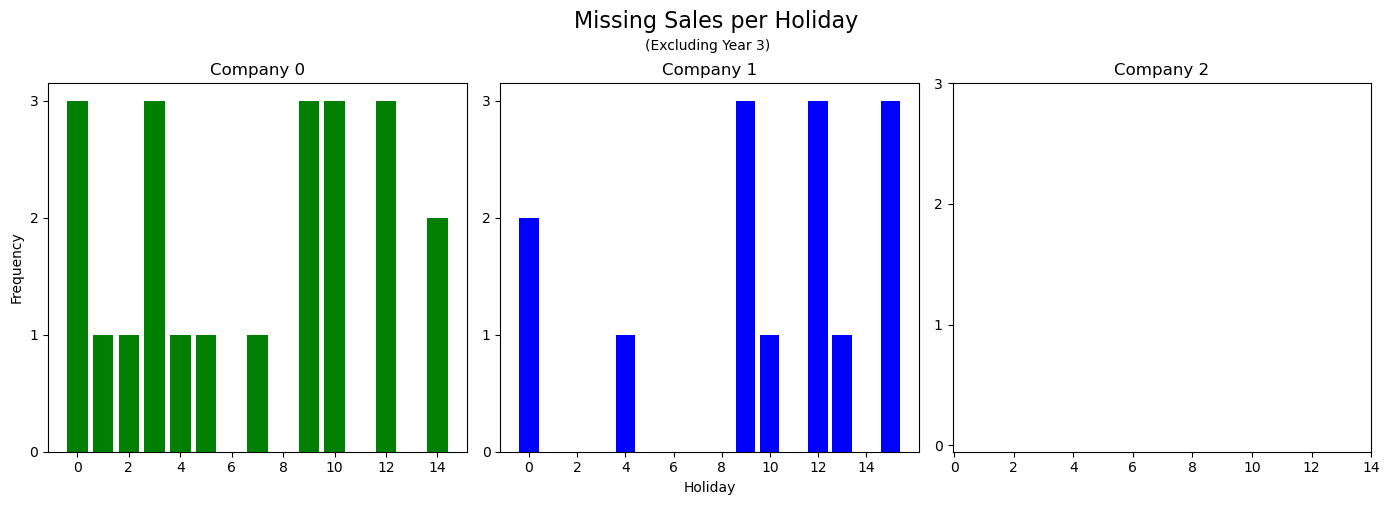

In [4]:
# Define negative sales as missing values
df.loc[df['Sales'] < 0, 'Sales'] = np.nan

# Missing sales on holidays
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))
companies = [0, 1, 2]
colors = ['green', 'blue', 'red']

for col, company in enumerate(companies):
    # Filter training set for missing sales on holidays for the current company, excluding year 3 (few datapoints)
    df_company = df[(df['Sales'].isna()) & (df['Company'] == company) & \
                    (df['Holiday'] != 16) & (df['Year'] != 3)]
    
    # Count the frequency of missing sales on each holiday
    holiday_frequency = df_company['Holiday'].value_counts()
    
    # Assume closed restaurant where frequency >= 2 (higher probabilty)
    for holiday, frequency in holiday_frequency.items():
        condition = (df['Sales'].isna()) & (df['Company'] == company) & \
                    (df['Holiday'] == holiday) & (frequency >= 2)
        df.loc[condition, 'Sales'] = 0
    
    # Plot missing sales per holiday
    x = df_company['Holiday'].value_counts().sort_index().index
    y = df_company['Holiday'].value_counts().sort_index().values
    
    axs[col].bar(x, y, color=colors[col])
    axs[col].set_title(f'Company {company}')
    axs[col].set_xticks(np.arange(0, len(df['Holiday'].unique())-1, 2))
    axs[col].set_yticks(np.arange(0, len(df['Year'].unique()), 1))
    
axs[1].set_xlabel('Holiday')
axs[0].set_ylabel('Frequency')
fig.suptitle('Missing Sales per Holiday', fontsize=16, x=0.515, y=1)
fig.text(0.464, 0.92, '(Excluding Year 3)', fontsize=10)
plt.tight_layout()
plt.show()

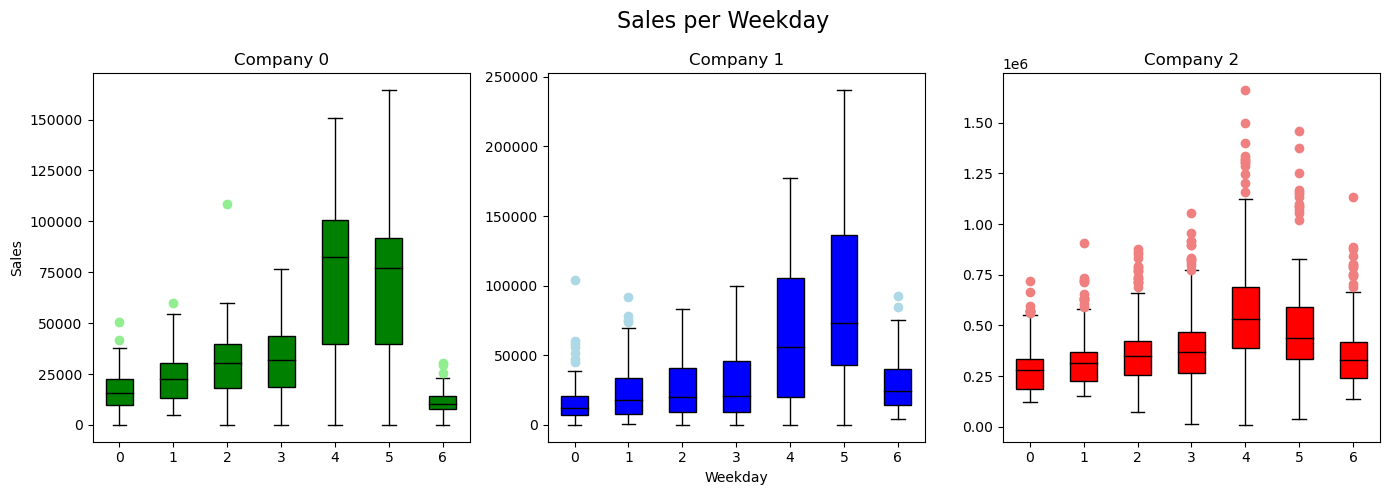

In [5]:
# Sales per weekday
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))
comparing_colors = ['lightgreen', 'lightblue', 'lightcoral']

for col, company in enumerate(companies):
    # Filter training set for current company and non-negative sales
    df_company = df[(df['Company'] == company) & (df['Sales'] >= 0)]
    
    # Identify outliers for each weekday
    for weekday in df_company['Weekday'].unique():
        # Filter dataframe for the current company and weekday
        df_weekday = df_company[df_company['Weekday'] == weekday]
        
        # Calculate quartiles and IQR for the current weekday
        Q1, Q3 = df_weekday['Sales'].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        
        # Calculate lower and upper bounds for outliers detection
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers based on lower and upper bounds
        outliers = (df_weekday['Sales'] < lower_bound) | (df_weekday['Sales'] > upper_bound)
        df.loc[df_weekday.index, 'Outlier'] = outliers.astype(int)
        
    # Plot sales per weekday
    df_weekdays = df_company.pivot(columns='Weekday', values='Sales')
    box_props = dict(facecolor=colors[col], edgecolor='black')
    flier_props = dict(markerfacecolor=comparing_colors[col], markeredgecolor=comparing_colors[col])
    rest_probs = dict(color='black')
    df_weekdays.boxplot(ax=axs[col], boxprops=box_props, whiskerprops=rest_probs, capprops=rest_probs, 
                        medianprops=rest_probs, flierprops=flier_props, grid=False, patch_artist=True)
    axs[col].set_title(f'Company {company}')
    
axs[1].set_xlabel('Weekday')
axs[0].set_ylabel('Sales') 
fig.suptitle('Sales per Weekday', fontsize=16, x=0.52)
plt.tight_layout()
plt.show()

# Define the remaining missing sales as outliers
df.loc[df['Outlier'].isna(), 'Outlier'] = 1

# Add weekend as a feature (friday/saturday)
df['Weekend'] = df['Date'].dt.weekday.isin([4, 5]).astype(int)
df_test['Weekend'] = df_test['Date'].dt.weekday.isin([4, 5]).astype(int)

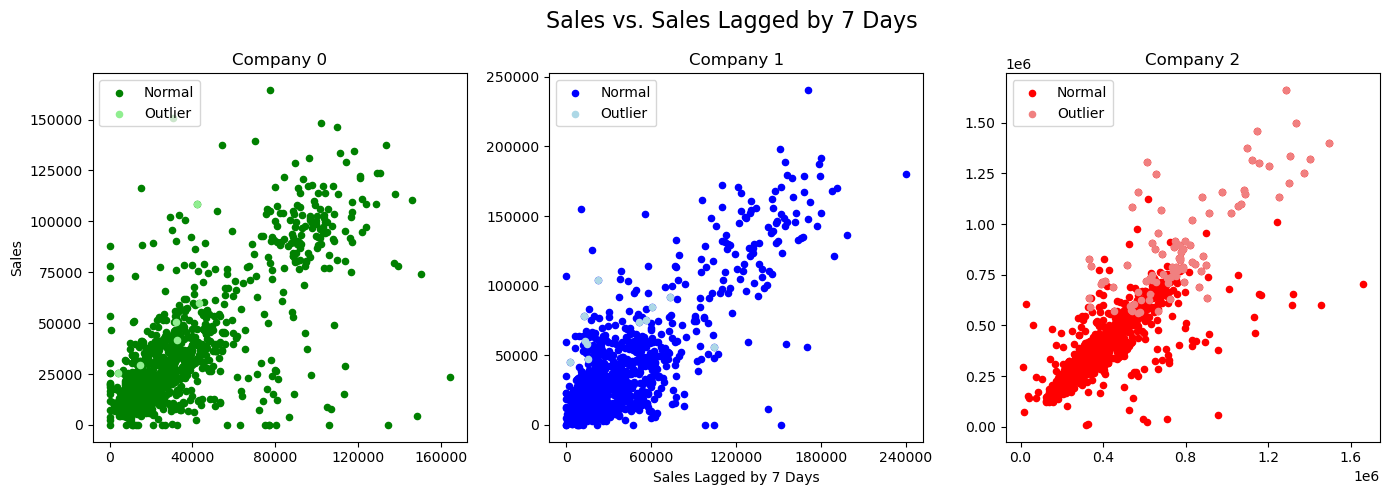

In [6]:
# Correlation between sales and sales lagged by 7 days
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))

for col, company in enumerate(companies):
    # Filter training set for the current company, non-negative sales and non-outliers
    df_company = df[(df['Company'] == company) & (df['Sales'] >= 0)].copy()
    
    # Shift sales by 7 days for comparison
    df_company['LAG7'] = df_company['Sales'].shift(7)
    
    # Identify outliers
    outliers = (df_company['Outlier'] == 1)
    
    # Plot correlation between sales and sales lagged by 7 days
    axs[col].scatter(df_company['LAG7'], df_company['Sales'], color=colors[col], label='Normal', s=20)
    axs[col].scatter(df_company.loc[outliers, 'LAG7'], df_company.loc[outliers, 'Sales'],
                     color=comparing_colors[col], label='Outlier', s=20)
    axs[col].set_title(f'Company {company}')
    axs[col].legend(loc='upper left')
    axs[col].xaxis.set_major_locator(plt.MaxNLocator(5))
    
axs[1].set_xlabel('Sales Lagged by 7 Days')
axs[0].set_ylabel('Sales')
fig.suptitle('Sales vs. Sales Lagged by 7 Days', fontsize=16, x=0.526)
plt.tight_layout()
plt.show()

# Add sales lagged by 7 days as a feature
df['temp'] = np.where(df['Outlier'] == 0, df['Sales'], np.nan)
df['LAG7'] = df.groupby('Company')['temp'].shift(7)
df.drop(columns='temp', inplace=True)

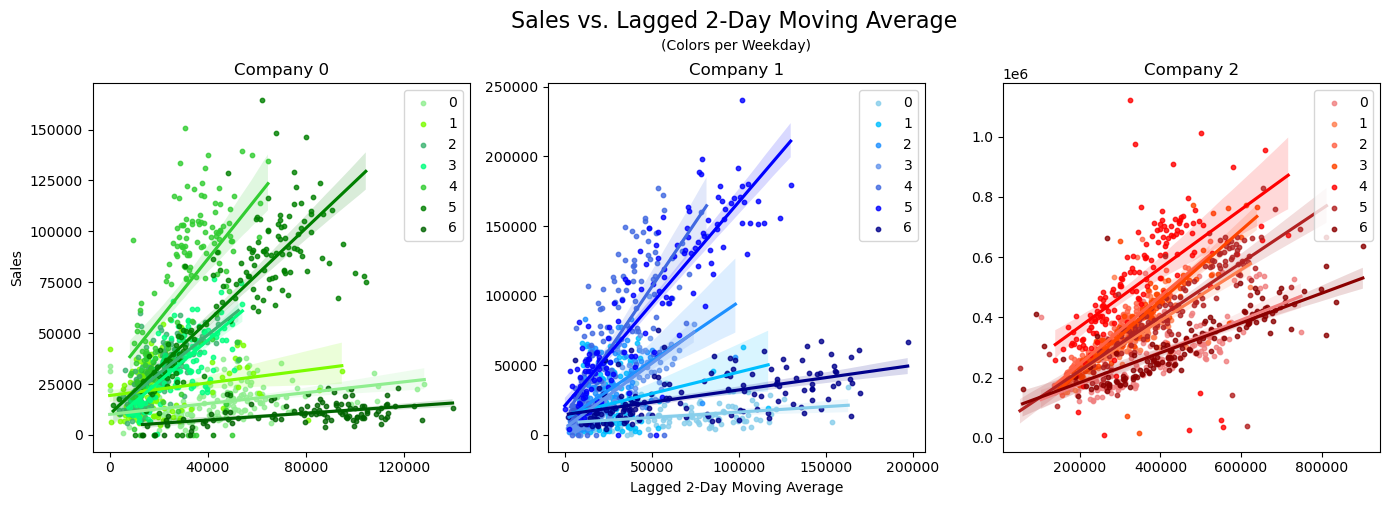

In [7]:
# Correlation between sales and lagged 2-day moving average
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))
weekday_colors = [['lightgreen', 'lawngreen', 'mediumseagreen', 'springgreen', 'limegreen', 'green', 'darkgreen'],
                  ['skyblue', 'deepskyblue', 'dodgerblue', 'cornflowerblue', 'royalblue', 'blue', 'darkblue'],
                  ['lightcoral', 'coral', 'tomato', 'orangered', 'red', 'firebrick', 'darkred']]

for col, company in enumerate(companies):
    # Filter training set for the current company, non-negative sales and non-outliers
    df_company = df[(df['Company'] == company) & (df['Sales'] >= 0) & (df['Outlier'] == 0)].copy()
    
    # Calculate 2-day moving average shifted by 1 day
    df_company['MA2'] = df_company['Sales'].rolling(window=2).mean().shift(1)
    
    # Plot relationship between sales and 2-day moving average per weekday
    for i in range(len(df_company['Weekday'].unique())):
        sns.regplot(x='MA2', y='Sales', data=df_company[df_company['Weekday'] == i], ax=axs[col],
                    color=weekday_colors[col][i], label=i, scatter_kws={'s': 10})
    axs[col].set_xlabel('')
    axs[col].set_ylabel('')
    axs[col].legend(loc='upper right')
    axs[col].set_title(f'Company {company}')
    axs[col].xaxis.set_major_locator(plt.MaxNLocator(5))
    
axs[1].set_xlabel('Lagged 2-Day Moving Average')
axs[0].set_ylabel('Sales')
fig.suptitle('Sales vs. Lagged 2-Day Moving Average', fontsize=16, x=0.528, y=1)
fig.text(0.476, 0.92, '(Colors per Weekday)', fontsize=10)
plt.tight_layout()
plt.show()

# Add 2-day moving average (lagged by 1-day) as a feature
df['temp'] = np.where(df['Outlier'] == 0, df['Sales'], np.nan)
df['MA2'] = df.groupby('Company')['temp'].rolling(window=2).mean().reset_index(level=0, drop=True)
df['MA2'] = df.groupby('Company')['MA2'].shift(1)
df.drop(columns='temp', inplace=True)

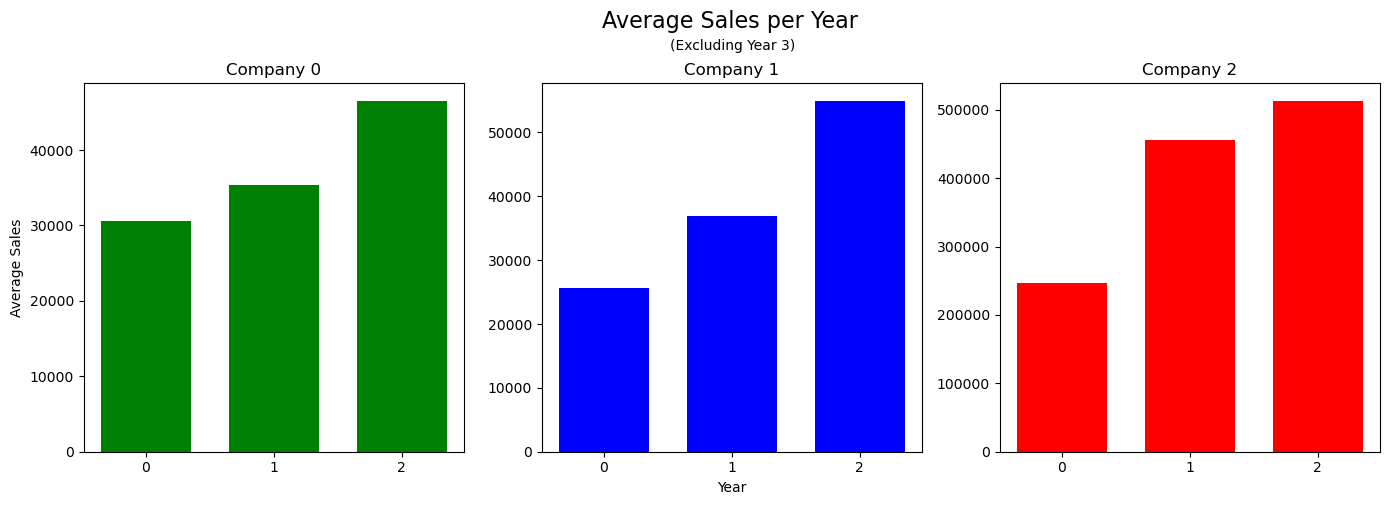

In [8]:
# Average sales per year (excluding year 3)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))

for col, company in enumerate(companies):
    # Filter training set for the current company with non-negative sales, excluding year 3 (few datapoints)
    df_company = df[(df['Company'] == company) & (df['Sales'] >= 0) & (df['Year'] != 3)]
    
    # Calculate average sales per year
    y = df_company.groupby('Year')['Sales'].mean()
    
    # Plot average sales per year
    axs[col].bar(y.index, y, color=colors[col], width=0.7)
    axs[col].set_title(f'Company {company}')
    axs[col].set_xticks(range(len(y.index)))
    
axs[1].set_xlabel('Year')
axs[0].set_ylabel('Average Sales')
fig.suptitle('Average Sales per Year', fontsize=16, x=0.525, y=1)
fig.text(0.482, 0.92, '(Excluding Year 3)', fontsize=10)
plt.tight_layout()
plt.show()

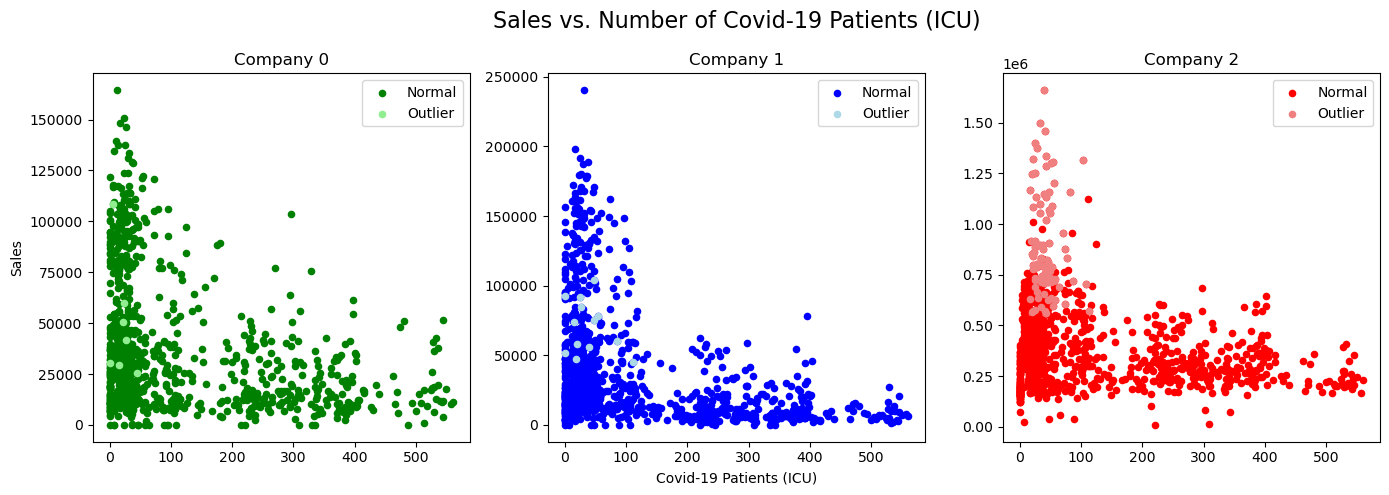

In [9]:
# Correlation between sales and Covid-19 patients (ICU)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))

for col, company in enumerate(companies):
    # Filter training set for the current company and non-negative sales
    df_company = df[(df['Company'] == company) & (df['Sales'] >= 0)]
    
    # Identify outliers
    outliers = (df_company['Outlier'] == 1)
    
    # Plot correlation between sales and Covid-19 patients (ICU)
    axs[col].scatter(df_company['CovidPatients'], df_company['Sales'], color=colors[col], label='Normal', s=20)
    axs[col].scatter(df_company.loc[outliers, 'CovidPatients'], df_company.loc[outliers, 'Sales'],
                     color=comparing_colors[col], label='Outlier', s=20)
    axs[col].set_title(f'Company {company}')
    axs[col].legend(loc='upper right')
    
axs[1].set_xlabel('Covid-19 Patients (ICU)')
axs[0].set_ylabel('Sales')
fig.suptitle('Sales vs. Number of Covid-19 Patients (ICU)', fontsize=16, x=0.53)
plt.tight_layout()
plt.show()

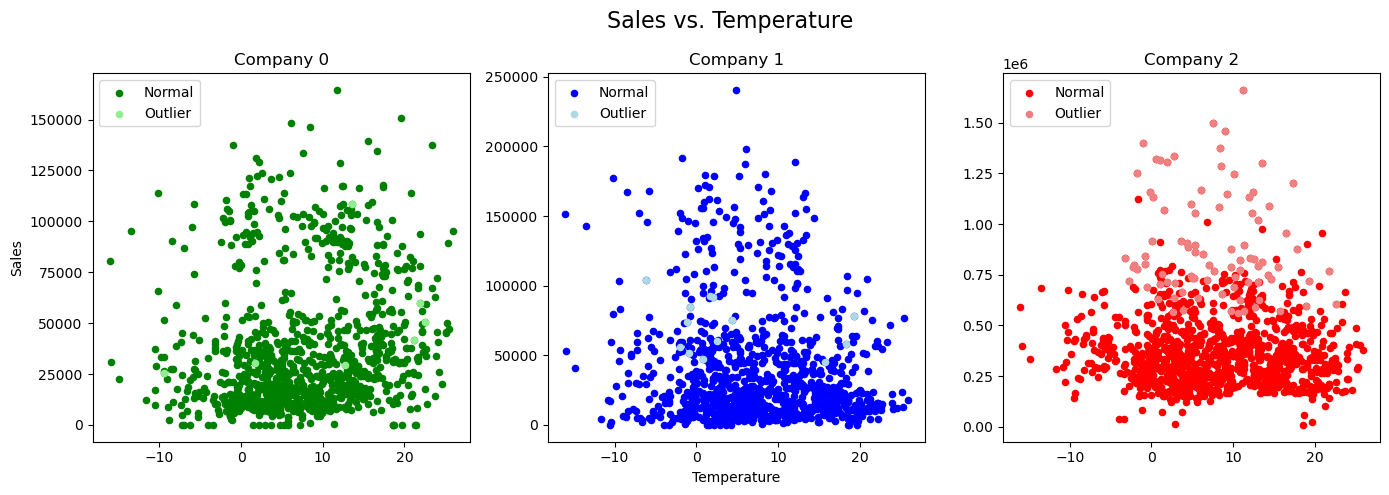

In [10]:
# Correlation between sales and temperature from previous day
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))

for col, company in enumerate(companies):
    # Filter training set for the current company and non-negative sales
    df_company = df[(df['Company'] == company) & (df['Sales'] >= 0)]
    
    # Identify outliers
    outliers = (df_company['Outlier'] == 1)
    
    # Plot relationship between sales and temperature from previous day
    axs[col].scatter(df_company['Temperature'], df_company['Sales'], color=colors[col], label='Normal', s=20)
    axs[col].scatter(df_company.loc[outliers, 'Temperature'], df_company.loc[outliers, 'Sales'],
                     color=comparing_colors[col], label='Outlier', s=20)
    axs[col].set_title(f'Company {company}')
    axs[col].legend(loc='upper left')
    
axs[1].set_xlabel('Temperature')
axs[0].set_ylabel('Sales')
fig.suptitle('Sales vs. Temperature', fontsize=16, x=0.525)
plt.tight_layout()
plt.show()

# Outlier Handling and Sales Imputation

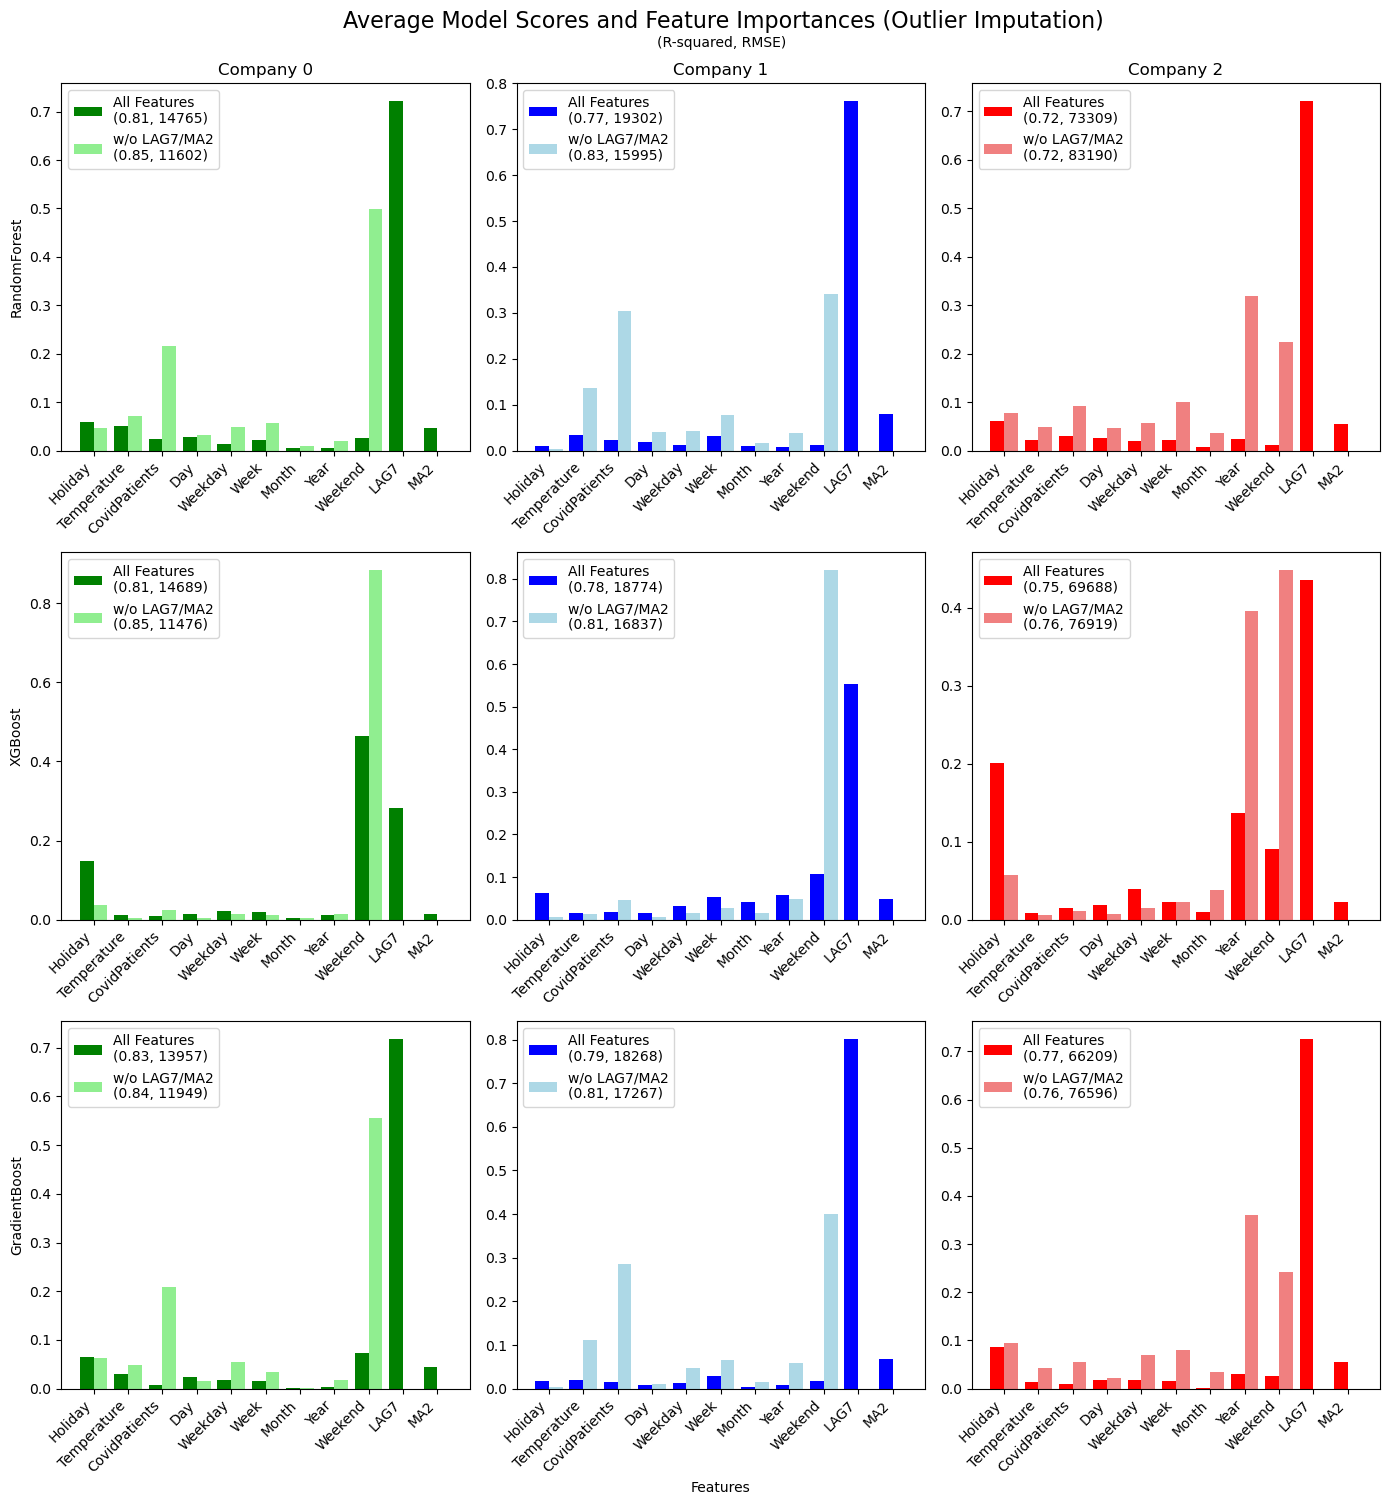

In [11]:
# Update sales for outliers
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14, 15))
models = ['RandomForest', 'XGBoost', 'GradientBoost']
test_sizes = [0.1, 0.2, 0.3]
drop_features = [['Date', 'Sales', 'Company', 'Outlier'],
                 ['Date', 'Sales', 'Company', 'Outlier', 'LAG7', 'MA2']]
labels = {}

# Update outlier sales based on the occurence of undefined values in LAG7 and MA2
for i, features in enumerate(drop_features):
    for col, company in enumerate(companies):
        # Filter training set for the company and non-outliers
        df_company = df[(df['Company'] == company) & (df['Outlier'] == 0)]
        
        # Exclude instances where LAG7 or MA2 is undefined 
        if i == 0:
            df_company = df_company[(df_company['LAG7'] >= 0) & (df_company['MA2'] >= 0)]  
            
        # Define features and target variable
        X = df_company.drop(columns=features)
        y = df_company['Sales']

        model_scores = {}
        for model_name in models:
            model_data = {'scores': [],
                          'feature_importances': [],
                          'instances': []}
            
            # Train-test split and model fitting for each testsize
            for size in test_sizes:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42,
                                                                    shuffle=True)
                # Choose model
                if model_name == 'RandomForest':
                    model = RandomForestRegressor()
                elif model_name == 'XGBoost':
                    model = xgboost.XGBRegressor()
                else:
                    model = GradientBoostingRegressor()
                
                # Train and test model
                model.fit(X_train, y_train)
                y_pred = np.maximum(model.predict(X_test), 0)
                
                # Calculate scores
                r2 = r2_score(y_test, y_pred)
                rmse = mean_squared_error(y_test, y_pred, squared=False)

                # Append scores, feature importances, and model instances to model_data
                model_data['scores'].append((r2, rmse))
                model_data['feature_importances'].append(model.feature_importances_)
                model_data['instances'].append(model)

            # Compute averages
            avg_r2 = np.mean([score[0] for score in model_data['scores']])
            avg_rmse = np.mean([score[1] for score in model_data['scores']])
            avg_importances = pd.DataFrame(model_data['feature_importances'], columns=X_train.columns).mean()
            
            # Append missing features for plotting
            if i == 1:
                avg_importances['LAG7'] = 0
                avg_importances['MA2'] = 0
            
            # Store data in model_scores dictionary
            model_scores[model_name] = (avg_r2, avg_rmse, avg_importances, model_data['instances'])
            
        # Define best model as the model with lowest RMSE
        best_model = min(model_scores, key=lambda k: model_scores[k][1])
        
        # Filter training set for the company and outliers
        X_outliers = df[(df['Company'] == company) & (df['Outlier'] == 1)]
        
        # Exclude instances where LAG7 or MA2 is undefined
        if i == 0:
            X_outliers = X_outliers[(X_outliers['LAG7'] >= 0) & (X_outliers['MA2'] >= 0)]
        X_outliers = X_outliers.drop(columns=features)
        
        # Compute new sales for outliers with best model for each model instance (testsize)
        predictions = []
        for model_instance in model_scores[best_model][3]:
            y_pred = np.maximum(model_instance.predict(X_outliers), 0)
            predictions.append(y_pred)
            
        # Compute averages and update value
        mean_predictions = np.mean(predictions, axis=0)
        df.loc[X_outliers.index, 'Sales'] = mean_predictions
        
        # Plot scores for each company and model
        for row, (model, scores) in enumerate(model_scores.items()):
            r2 = round(scores[0], 2)
            rmse = round(scores[1])
            feature_importances = scores[2]
            
            bar_width = 0.4
            if i == 0:
                bar_positions = np.arange(len(feature_importances.index)) - (bar_width/2)
                axs[row, col].bar(bar_positions, feature_importances, color=colors[col], width=bar_width)
                labels[(row, col)] = (r2, rmse)
            else:
                bar_positions = np.arange(len(feature_importances.index)) + (bar_width/2)
                axs[row, col].bar(bar_positions, feature_importances, color=comparing_colors[col], width=bar_width)
                axs[row, col].legend(labels=[f'All Features\n({labels[(row, col)][0]}, {labels[(row, col)][1]})',
                                             f'w/o LAG7/MA2\n({r2}, {rmse})'], loc='upper left')
            
            axs[row, col].set_xticks(range(len(feature_importances.index)))
            axs[row, col].set_xticklabels(feature_importances.index, rotation=45, ha='right')
            axs[row, 0].set_ylabel(model)
            axs[0, col].set_title(f'Company {company}')
            
axs[2, 1].set_xlabel('Features')
fig.suptitle('Average Model Scores and Feature Importances (Outlier Imputation)', fontsize=16, x=0.52, y=1)
fig.text(0.473, 0.975, '(R-squared, RMSE)', fontsize=10)
plt.tight_layout()
plt.show()

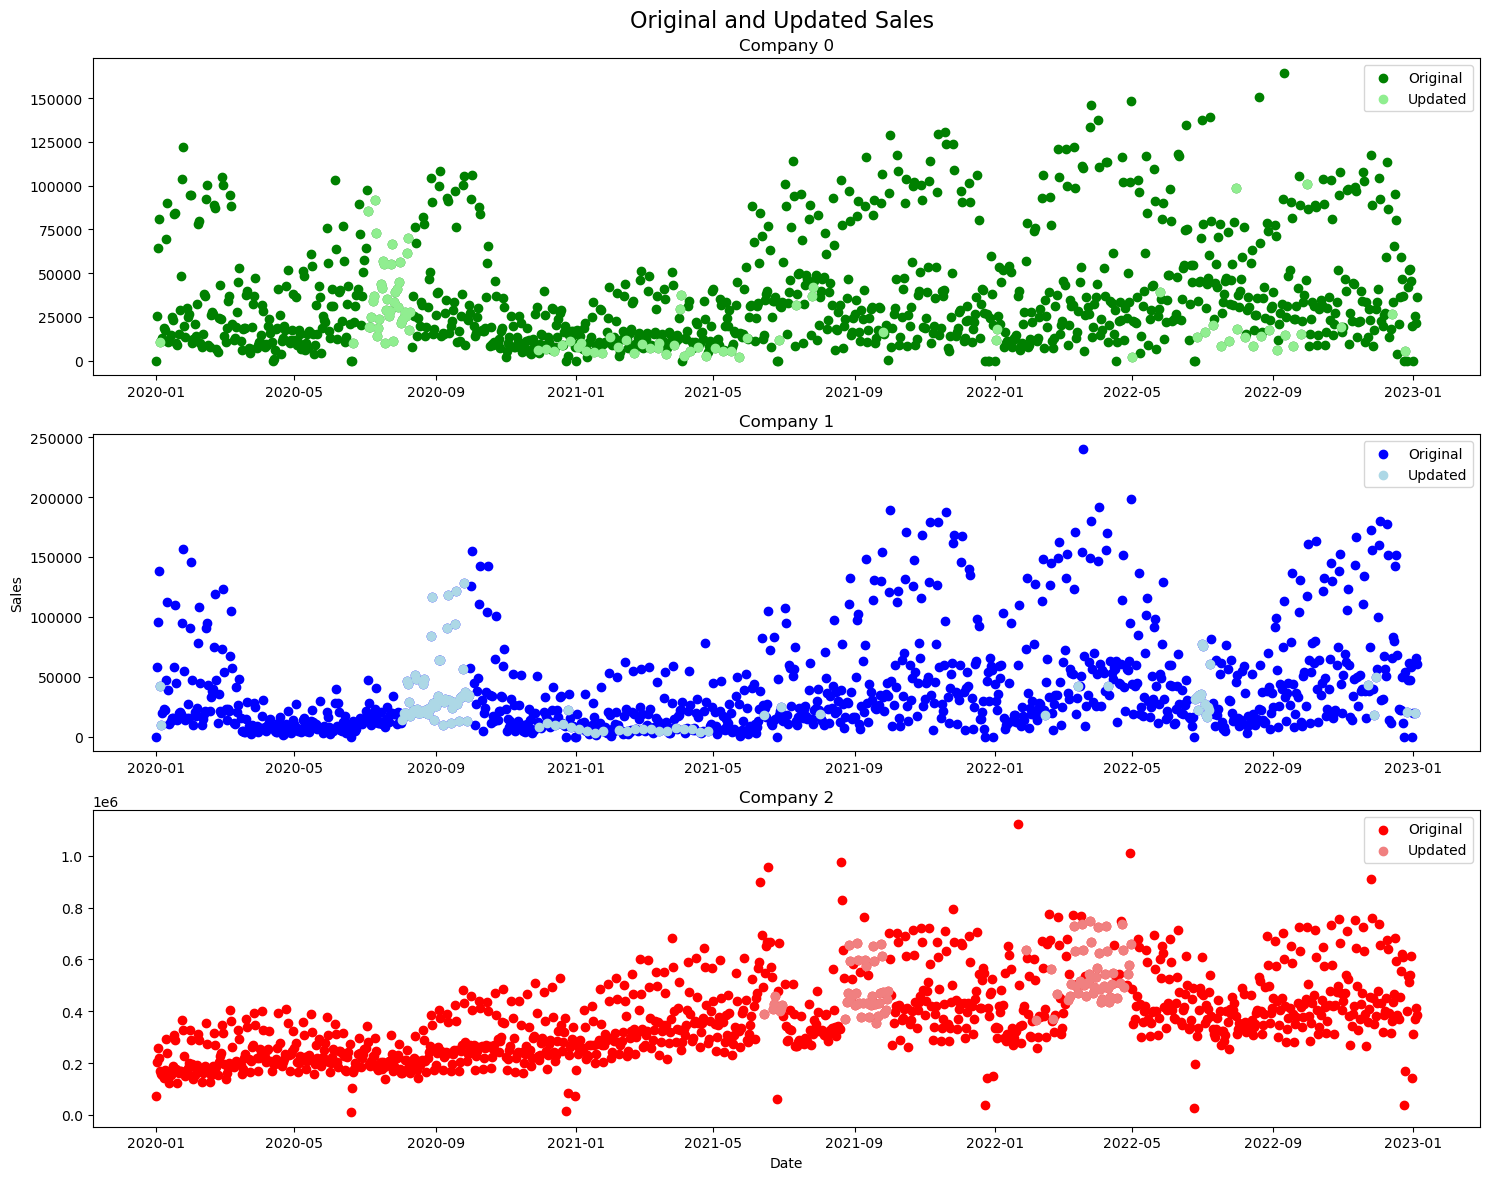

In [12]:
# Visulize updated values for outliers
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))

for row, company in enumerate(companies):
    # Filter training set for the company
    df_company = df[df['Company'] == company]
    
    # Identify updated outliers
    updated = ((df_company['Outlier'] == 1) & (df_company['Sales'] >= 0))

    # Plot original and updated values
    axs[row].scatter(df_company['Date'], df_company['Sales'], color=colors[row], label='Original')
    axs[row].scatter(df_company.loc[updated, 'Date'], df_company.loc[updated, 'Sales'],
                     color=comparing_colors[row], label='Updated')
    axs[row].set_title(f'Company {company}')
    axs[row].legend()
    
axs[2].set_xlabel('Date')
axs[1].set_ylabel('Sales')
fig.suptitle('Original and Updated Sales', fontsize=16, x=0.525)
plt.tight_layout()
plt.show()

In [13]:
# Update moving averages and lagged sales based on updated sales
df['LAG7'] = df.groupby('Company')['Sales'].shift(7)
df['MA2'] = df.groupby('Company')['Sales'].rolling(window=2).mean().reset_index(level=0, drop=True)
df['MA2'] = df.groupby('Company')['MA2'].shift(1)

# Drop outlier column
df.drop(columns='Outlier', inplace=True)
df.head()

,Date,Company,Sales,Holiday,Temperature,CovidPatients,Day,Weekday,Week,Month,Year,Weekend,LAG7,MA2
0,2020-01-01,2,72608.623649,0,3.7,0,1,2,1,1,0,0,NaN,NaN
1,2020-01-01,1,0.000000,0,3.7,0,1,2,1,1,0,0,NaN,NaN
2,2020-01-01,0,0.000000,0,3.7,0,1,2,1,1,0,0,NaN,NaN
3,2020-01-02,2,205074.093589,16,3.3,0,2,3,1,1,0,0,NaN,NaN
4,2020-01-02,1,57957.790779,16,3.3,0,2,3,1,1,0,0,NaN,NaN


# Model Selection and Evaluation (Training Set)

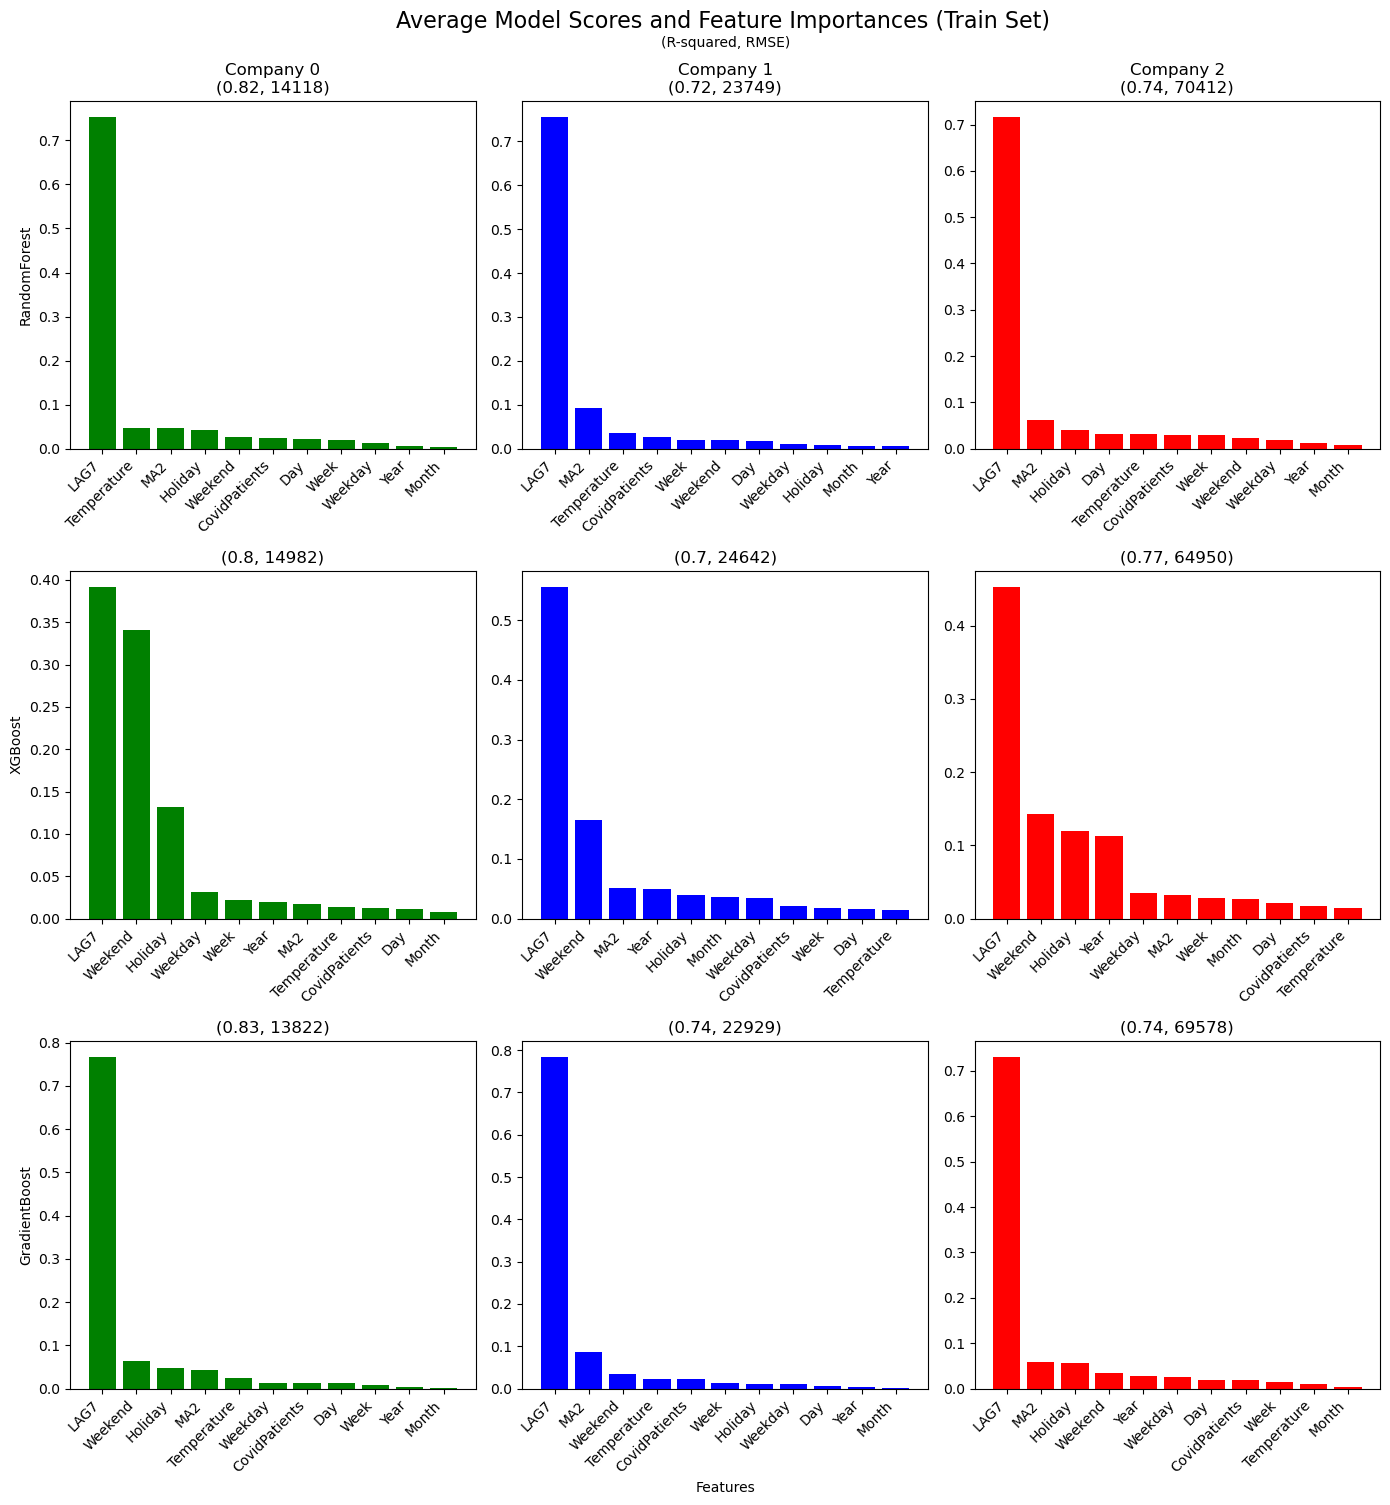

In [14]:
# Train, test and evaluate models
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14, 15))
best_predictions = {}

for col, company in enumerate(companies):
    # Filter training set for the current company and drop rows with missing values
    df_company = df[df['Company'] == company].dropna()
    
    # Define features and target variable
    X = df_company.drop(columns=['Date', 'Sales', 'Company'])
    y = df_company['Sales']
    
    model_data = {}
    
    for model_name in models:
        model_data[model_name] = {'scores': [],
                                  'predictions': [],
                                  'feature_importances': [],
                                  'instances': []}
        
        # Train-test split and model fitting for each testsize       
        for size in test_sizes:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42,
                                                                shuffle=False)
            # Choose model
            if model_name == 'RandomForest':
                model = RandomForestRegressor()
            elif model_name == 'XGBoost':
                model = xgboost.XGBRegressor()
            else:
                model = GradientBoostingRegressor()
            
            # Train and test model
            model.fit(X_train, y_train)
            y_pred = np.maximum(model.predict(X_test), 0)
            
            # Calculate scores
            r2 = r2_score(y_test, y_pred)
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            
            # Append scores, feature importances, and model instances to model_data
            model_data[model_name]['predictions'].append(y_pred)
            model_data[model_name]['scores'].append((r2, rmse))
            model_data[model_name]['feature_importances'].append(model.feature_importances_)
            model_data[model_name]['instances'].append(model)
        
        # Compute averages
        avg_r2 = np.mean([score[0] for score in model_data[model_name]['scores']])
        avg_rmse = np.mean([score[1] for score in model_data[model_name]['scores']])
        avg_importances = pd.DataFrame(model_data[model_name]['feature_importances'],
                                       columns=X_train.columns).mean().sort_values(ascending=False)
        
        # Compute mean predictions over all test sizes
        predictions = model_data[model_name]['predictions']
        index = min(len(lst) for lst in predictions)
        mean_predictions = np.mean([lst[-index:] for lst in predictions], axis=0)
        
        # Update model_data with computed averages
        model_data[model_name]['predictions'] = mean_predictions
        model_data[model_name]['scores'] = (avg_r2, avg_rmse)
        model_data[model_name]['feature_importances'] = avg_importances
    
    # Find the best model based on the lowest RMSE score and save values
    best_model = min(model_data, key=lambda k: model_data[k]['scores'][1])
    best_predictions[company] = (best_model,
                                 model_data[best_model]['predictions'],
                                 model_data[best_model]['instances'],
                                 model_data[best_model]['scores'])
    
    # Plot scores for each company and model
    for row, (model, data) in enumerate(model_data.items()):
        r2 = round(data['scores'][0], 2)
        rmse = round(data['scores'][1])
        features = data['feature_importances']
        
        if row == 0:
            axs[row, col].set_title(f'Company {company}\n({r2}, {rmse})')
        else:
            axs[row, col].set_title(f'({r2}, {rmse})')
        axs[row, col].bar(features.index, features, color=colors[col])
        axs[row, col].set_xticks(range(len(features.index)))
        axs[row, col].set_xticklabels(features.index, rotation=45, ha='right')
        axs[row, 0].set_ylabel(model)

axs[2, 1].set_xlabel('Features')
fig.suptitle('Average Model Scores and Feature Importances (Train Set)', fontsize=16, x=0.52, y=1)
fig.text(0.476, 0.975, '(R-squared, RMSE)', fontsize=10)     
plt.tight_layout()
plt.show()

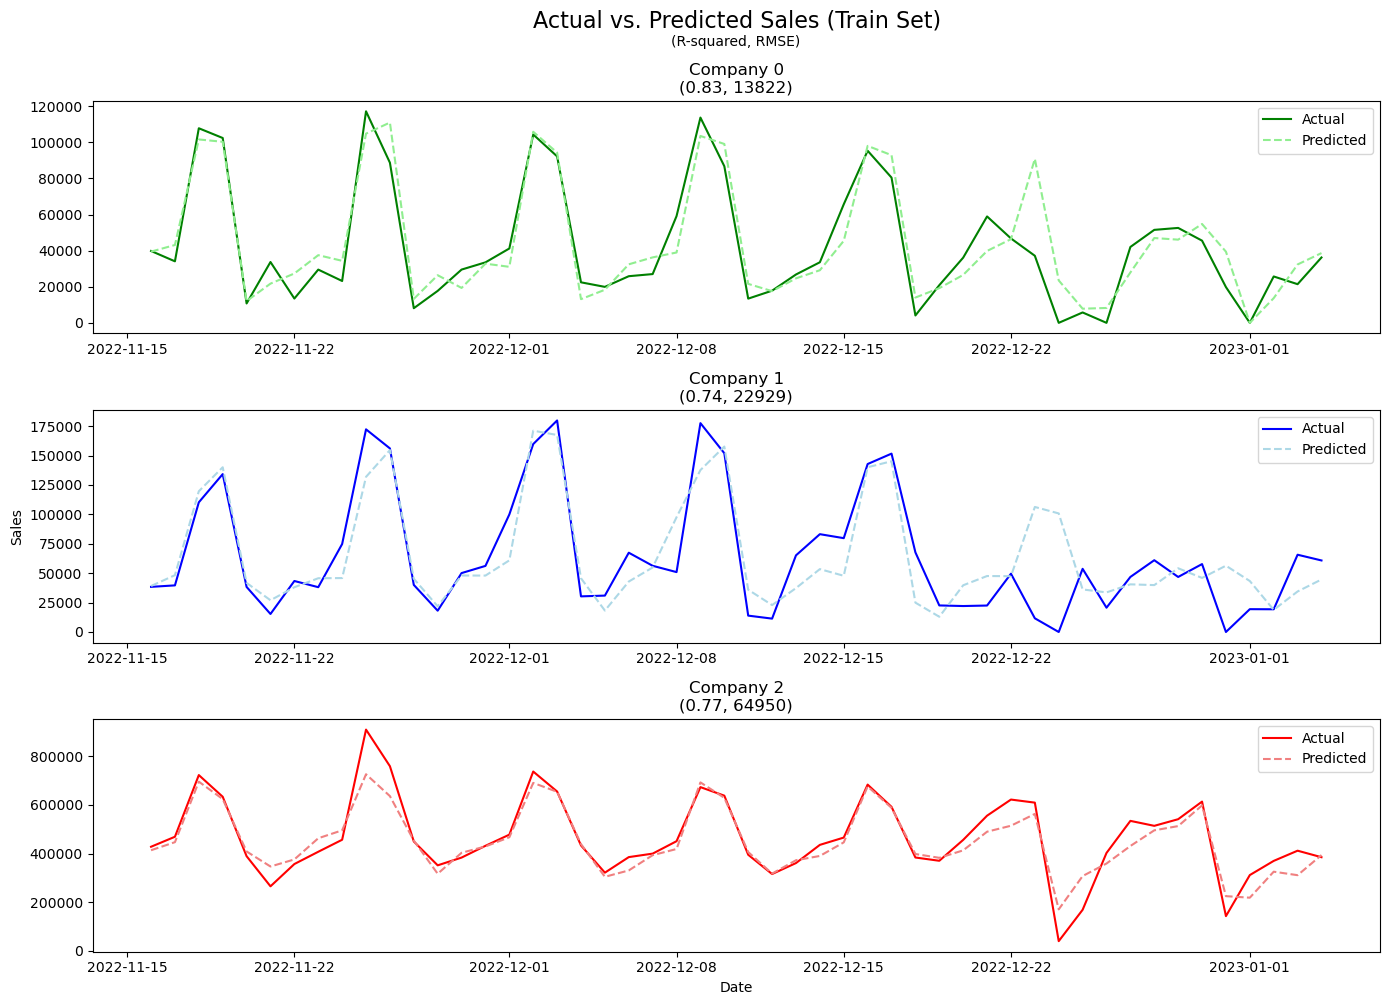

In [15]:
# Compare predictions from best model to actual sales
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 10))

for row, company in enumerate(companies):
    # Filter training set for the current company
    df_company = df[df['Company'] == company]
    
    # Retrieve predicted sales and scores from the best model
    predicted_sales = best_predictions[company][1]
    r2 = round(best_predictions[company][3][0], 2)
    rmse = round(best_predictions[company][3][1])
    
    # Number of days to plot
    days = 50
    
    # Plot actual and predicted sales for the last 50 days
    axs[row].plot(df_company['Date'][-days:], df_company['Sales'][-days:], color=colors[row], label='Actual')
    axs[row].plot(df_company['Date'][-days:], predicted_sales[-days:], color=comparing_colors[row],
                  label='Predicted', linestyle='--')
    axs[row].set_title(f'Company {company}\n({r2}, {rmse})')
    axs[row].legend()
    
axs[2].set_xlabel('Date')
axs[1].set_ylabel('Sales')
fig.suptitle('Actual vs. Predicted Sales (Train Set)', fontsize=16, x=0.53, y=1)
fig.text(0.483, 0.964, '(R-squared, RMSE)', fontsize=10) 
plt.tight_layout()
plt.show()

# Future Sales Prediction (Test Set)

In [16]:
# Combine training and test set
df_test.sort_values(by=['Date', 'Company'], ascending=[True, False], inplace=True)
df_combined = pd.merge(df, df_test, how='outer')

# Recalulate lagged sales by 7 days and 2-day moving average
df_combined['LAG7'] = df_combined.groupby('Company')['Sales'].shift(7)
df_combined['MA2'] = df_combined.groupby('Company')['Sales'].rolling(window=2).mean().reset_index(level=0, drop=True)
df_combined['MA2'] = df_combined.groupby('Company')['MA2'].shift(1)
df_combined

,Date,Company,Sales,Holiday,Temperature,CovidPatients,Day,Weekday,Week,Month,Year,Weekend,LAG7,MA2
0,2020-01-01,2,72608.623649,0,3.7,0,1,2,1,1,0,0,NaN,NaN
1,2020-01-01,1,0.000000,0,3.7,0,1,2,1,1,0,0,NaN,NaN
2,2020-01-01,0,0.000000,0,3.7,0,1,2,1,1,0,0,NaN,NaN
3,2020-01-02,2,205074.093589,16,3.3,0,2,3,1,1,0,0,NaN,NaN
4,2020-01-02,1,57957.790779,16,3.3,0,2,3,1,1,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3340,2023-01-18,1,NaN,16,1.7,22,18,2,3,1,3,0,NaN,NaN
3341,2023-01-18,0,NaN,16,1.7,22,18,2,3,1,3,0,NaN,NaN
3342,2023-01-19,2,NaN,16,1.8,18,19,3,3,1,3,0,NaN,NaN
3343,2023-01-19,1,NaN,16,1.8,18,19,3,3,1,3,0,NaN,NaN


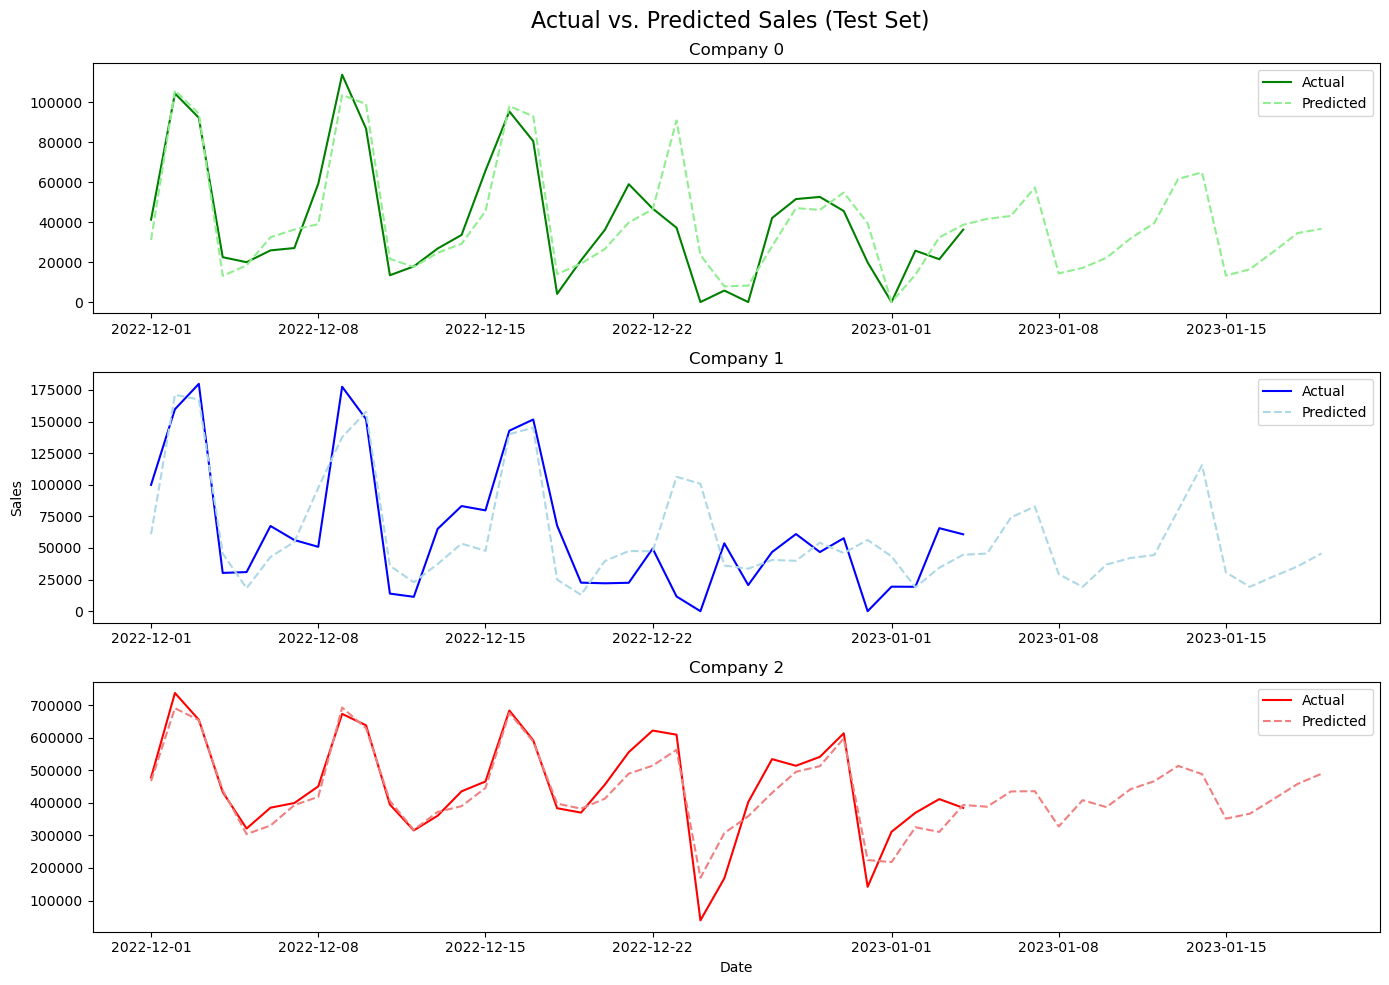

In [17]:
# Predict sales on test set
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 10))

for row, company in enumerate(companies):
    # Filter data for the current company on training set
    df_company = df[df['Company'] == company]
    
    # Filter data for the current company on combined set
    X_company = df_combined[df_combined['Company'] == company].copy()
    X_company.drop(columns='Company', inplace=True)
    
    # Retrieve the best model instances
    model_instances = best_predictions[company][2]
    
    # Determine the range of indices corresponding to the test set
    end_index = len(X_company)
    start_index = end_index - len(df_test['Date'].unique())
    
    # Make predictions for each day in the test set
    for day in range(start_index, end_index):
        # Extract features for the current day
        X_day = X_company.iloc[day].to_frame().T
        X_day.drop(columns=['Date', 'Sales'], inplace=True)
        X_day = X_day.astype(float)
        
        # Make predictions using each model instance (testsize)
        predictions = []
        for model_instance in model_instances:
            y_pred = np.maximum(model_instance.predict(X_day), 0)
            predictions.append(y_pred)
        
        # Update the sales value for the current day with the mean prediction
        X_company.loc[X_day.index, 'Sales'] = np.mean(predictions, axis=0)
        
        # Update the moving average and lagged sales values
        X_company['MA2'] = X_company['Sales'].rolling(window=2).mean().shift(1)
        X_company['LAG7'] = X_company['Sales'].shift(7)
    
    # Number of days to plot and test days
    days = 50
    test_days = len(df_test['Date'].unique())
    
    # Extend previous predicted sales with current predicitons 
    predicted_sales = np.concatenate((best_predictions[company][1], X_company['Sales'][-test_days:].values))
    
    # Plot actual and predicted sales for the last 50 days
    axs[row].plot(df_company['Date'][-(days-test_days):], df_company['Sales'][-(days-test_days):],
                  color=colors[row], label='Actual')
    axs[row].plot(X_company['Date'][-days:], predicted_sales[-days:], color=comparing_colors[row],
                  label='Predicted', linestyle='--')
    axs[row].set_title(f'Company {company}')
    axs[row].legend()
    
axs[2].set_xlabel('Date')
axs[1].set_ylabel('Sales')
fig.suptitle('Actual vs. Predicted Sales (Test Set)', fontsize=16, x=0.525)
plt.tight_layout()
plt.show()